# Setup enviorment

In [1]:
import os
import logging
import tensorflow as tf
# Set TensorFlow logging level to suppress debug messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '0' (default) shows all logs, '1' shows only warnings and errors, '2' shows only errors
# Disable logging of debug messages from TensorFlow
tf.get_logger().setLevel(logging.ERROR)
from Preprocessing.time_series_preprocessing import train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

# Base LSTM

The code primarily focuses on building deep learning models for regression and classification tasks using LSTM (Long Short-Term Memory) layers. It provides utilities to create, compile, and train the models.

---

## Imports

- **TensorFlow and Keras**: Used for creating and training deep learning models.
- **TensorFlow Addons**: Provides extra functionalities not available in core TensorFlow.
- **Pretrained_DL_Models**: A custom module (not provided in the snippet) presumably containing pretrained models/backbones.
- **matplotlib**: For plotting graphs.
- **warnings**: For suppressing Python warnings.

---

## Custom Functions and Layers

1. **smape**:
    - A custom loss function representing the Symmetric Mean Absolute Percentage Error.

2. **CustomTimeDistributed**:
    - An inherited version of the Keras TimeDistributed layer that behaves differently if all input values are zeros.

3. **ZeroInputCheckLayer**:
    - A custom layer that checks if all input values are zeros. If they are, it returns a learnable vector; otherwise, it passes the input through the specified base CNN layer.

---

## Core Functions

1. **create_model**:
    - Creates and returns a deep learning model for regression.
    - Parameters:
        - `lstm_layers`: List specifying the number of LSTM units for each LSTM layer.
        - `nn_layers`: List specifying the number of neurons for each Dense layer.
        - Various other parameters to fine-tune the model's architecture and behavior.

2. **create_model_classification**:
    - Creates and returns a deep learning model for classification.
    - Parameters are similar to the `create_model` function but tailored for classification tasks.

3. **create_monitor**:
    - Creates an EarlyStopping callback for training the models. It stops training once a monitored quantity has stopped improving.
    - Parameters:
        - `monitor_var`: The metric to be monitored.
        - `min_delta`: Minimum change in the monitored quantity to qualify as an improvement.
        - `patience`: Number of epochs with no improvement after which training will be stopped.
        - Various other parameters to control its behavior.

4. **train_model**:
    - Trains a given model using the provided data and optionally plots the training and validation losses.
    - Parameters:
        - `model`: The Keras model to be trained.
        - `train_X`: Training data.
        - `train_y`: Labels for the training data.
        - `val_X`: Validation data.
        - `val_y`: Labels for the validation data.
        - Various other parameters to control the training process.

---

## Remarks

The code provides an extensive setup to easily create, compile, and train LSTM-based models for both regression and classification tasks. The provided utility functions and layers add extra functionalities like custom loss computations and dynamic behavior based on input values.

To use the code effectively, one needs to ensure they have TensorFlow and the necessary modules installed. Additionally, the `Models.Pretrained_DL_Models` module, which presumably contains the `get_backbone` function, needs to be available and correctly structured.


In [2]:
# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, BatchNormalization, TimeDistributed
import tensorflow_addons as tfa

from Models.Pretrained_DL_Models import get_backbone

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

""" Create the Model for Regression """
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

""" Add the Learnable vector """
class CustomTimeDistributed(tf.keras.layers.TimeDistributed):
    def call(self, inputs):
        # Check if all values in the input are 0
        if tf.reduce_all(tf.equal(inputs, 0)):
            # Return the input without passing it through the cnn_base layer
            return inputs

        # Pass the input through the cnn_base layer and the rest of the layers
        else:
            return super().call(inputs)


# Custom Layer for zero input check
class ZeroInputCheckLayer(tf.keras.layers.Layer):
    def __init__(self, projection, cnn_base):
        super(ZeroInputCheckLayer, self).__init__()
        self.projection = projection
        self.cnn_base = cnn_base
        self.learnable_vector = self.add_weight(
            name='learnable_vector',
            shape=(projection,),
            trainable=True,
            initializer='zeros',
            constraint=tf.keras.constraints.NonNeg()
        )

    def call(self, inputs):
        print('tf.shape(inputs)',tf.shape(inputs))

        if tf.reduce_all(inputs == 0):
            outs = tf.expand_dims(self.learnable_vector, axis=0)
            print('tf.shape(outs)',tf.shape(outs))
            return outs
        else:
            outs = self.cnn_base(inputs)
            print('tf.shape(outs)',tf.shape(outs))
            return outs



def create_model(lstm_layers=[256,128,64], nn_layers=[60, 1], sequence=3, features=1024, dense_acivation='relu', recurrent_cells='LSTM', bidirectional=False, backbone='ResNet50V2', weights='imagenet', freeze=True, projection=1024, learnable_vector=False, meta_features = False):

    # Create a Sequential Model
    model = Sequential()


    if type(features) == list or type(features) == tuple and sequence != 0:
        # Get backbone:
        # Possible options to backbone: # 'ViT' # 'ConvNeXtTiny' # 'ConvNeXtSmall' # 'ConvNeXtBase' # 'ResNet50V2' # 'VGG16' # 'MobileNetV2'
        # Possible options to weights: # 'imagenet' # None # 'sentinel_vae' # 'sentinel_ae'
        #backbone = 'ConvNeXtTiny' # 'ViT' # 'ConvNeXtTiny' # 'ConvNeXtSmall' # 'ConvNeXtBase' # 'ResNet50V2' # 'VGG16' # 'MobileNetV2'
        #weights = 'imagenet' # 'imagenet' # None # 'sentinel_vae' # 'sentinel_ae'
        #freeze = False
        cnn_base = get_backbone(features, backbone, freeze=freeze, weights=weights)

        if learnable_vector:
            model.add(TimeDistributed(ZeroInputCheckLayer(projection, cnn_base), input_shape=((sequence,) + features)))
        else:
            model.add(TimeDistributed(cnn_base, input_shape = ((sequence,) + features)))
        # Projection layer
        model.add(tf.keras.layers.TimeDistributed(Dense(projection)))
        # model.add(tf.keras.layers.LSTM(120, dropout=0.1, return_sequences=True))
        features = projection


    if sequence != 0:
        # Add LSTM Layers
        for i, lstm_layer in enumerate(lstm_layers):
            if i < (len(lstm_layers) - 1):
                if bidirectional:
                    if recurrent_cells == 'LSTM':
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                    elif recurrent_cells == 'GRU':
                        model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                    else:
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                else:
                    if recurrent_cells == 'LSTM':
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                    elif recurrent_cells == 'GRU':
                        model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                    else:
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                features = lstm_layer
            else:
                if bidirectional:
                    if recurrent_cells == 'LSTM':

                          model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    elif recurrent_cells == 'GRU':
                        model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                    else:
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                else:
                    if recurrent_cells == 'LSTM':

                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    elif recurrent_cells == 'GRU':
                        model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    else:
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
    else:
      if meta_features == False:
          for i, nn_layer in enumerate(lstm_layers):
              if i < (len(nn_layers) - 1):
                  model.add(Dense(nn_layer, activation=dense_acivation))
                  # model.add(BatchNormalization())
              else:
                  model.add(Dense(nn_layer))
      else:
          for i, nn_layer in enumerate(nn_layers):
              if i < (len(nn_layers) - 1):
                  model.add(Dense(nn_layer,   kernel_initializer='lecun_normal', activation='selu'))
                  model.add(BatchNormalization())
              else:
                  model.add(Dense(nn_layer))
    # model.add(BatchNormalization())
    # Add Dense Layers
    if meta_features == False:
      for i, nn_layer in enumerate(nn_layers):
          if i < (len(nn_layers) - 1):
              model.add(Dense(nn_layer, activation=dense_acivation))
              model.add(BatchNormalization())
          else:
              model.add(Dense(nn_layer))
    else:

      for i, nn_layer in enumerate(nn_layers):
          if i < (len(nn_layers) - 1):
              model.add(Dense(nn_layer,   kernel_initializer='lecun_normal', activation='selu'))
              model.add(BatchNormalization())
          else:
              model.add(Dense(nn_layer))

    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
    else:
        opt = tf.keras.optimizers.Adam(lr=0.001)


    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]


    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model


""" Create the Model for Classification """
def create_model_classification(lstm_layers=[120, 240], nn_layers=[60, 3], sequence=3, features=1024, dense_acivation='relu', recurrent_cells='LSTM', bidirectional=False):

    # Create a Sequential Model
    model = Sequential()

    # Add LSTM Layers
    for i, lstm_layer in enumerate(lstm_layers):
        if i < (len(lstm_layers) - 1):
            if bidirectional:
                if recurrent_cells == 'LSTM':
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                elif recurrent_cells == 'GRU':
                    model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                else:
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
            else:
                if recurrent_cells == 'LSTM':
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                elif recurrent_cells == 'GRU':
                    model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                else:
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
            features = lstm_layer
        else:
            if bidirectional:
                if recurrent_cells == 'LSTM':
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                elif recurrent_cells == 'GRU':
                    model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                else:
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
            else:
                if recurrent_cells == 'LSTM':
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                elif recurrent_cells == 'GRU':
                    model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                else:
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
    model.add(BatchNormalization())
    # Add Dense Layers
    for i, nn_layer in enumerate(nn_layers):
        if i < (len(nn_layers) - 1):
            model.add(Dense(nn_layer, activation=dense_acivation))
            model.add(BatchNormalization())
        else:
            model.add(Dense(nn_layer, activation='softmax'))

    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam()
    else:
        opt = tf.keras.optimizers.Adam()

    # Metrics
    metrics = [
        tf.keras.metrics.AUC(name='auc'), #, multi_label=True, num_labels=3),
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tfa.metrics.F1Score(num_classes=3, threshold=0.5)
        ]

    #loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)


    return model



""" Train the Model """
def create_monitor(monitor_var='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto', restore_best_weights=True):
    # EarlyStopping:
    monitor = EarlyStopping(monitor=monitor_var, min_delta=min_delta, patience=patience,
                            verbose=verbose, mode=mode, restore_best_weights=restore_best_weights)
    return monitor

# fit network
def train_model(model, train_X, train_y, val_X, val_y, monitor, plot=None, epochs=50, batch_size=16, verbose=0, weights=None):
    if monitor:
        monitor = create_monitor()
        if weights:
            history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False, callbacks=[monitor], class_weight=weights)
        else:
            history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False, callbacks=[monitor], class_weight=weights)
    else:
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False)

    if plot:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Train - Validation Loss Plot')
        plt.legend()
        plt.show()





# Create Aggregate Models

Deep learning architectures that focus on merging and aggregating the outputs from various models using techniques such as attention mechanisms.

## 1. Imports

Libraries and modules required to create and handle the deep learning models.

## 2. Custom SMAPE Loss Function

Symmetric Mean Absolute Percentage Error (SMAPE) is a custom loss function which measures the accuracy of predictions.

## 3. Attention and Fusion Models

### 3.1. Gated Attention Network

A neural network architecture that utilizes a gating mechanism over the attention weights.

### 3.2. Fusion Network

A neural network architecture that merges features using a specific mechanism.

## 4. Kronecker Product Layer

Layer that computes the outer product between two tensors.

## 5. Model Aggregation Functions

### 5.1. Regression Aggregation Model

Function that aggregates features from multiple models and generates a final regression output.

### 5.2. Attention-based Regression Aggregation Model

This function integrates an attention mechanism while aggregating features from multiple models.

### 5.3. Classification Aggregation Model

Function to merge outputs of various models for classification tasks.

## Remarks:

- The main purpose of the provided code is to aggregate or fuse outputs from various models.
- Attention mechanisms are used to assign different importances to different features while fusing.
- The models and functions are flexible enough to handle up to three input models.
- Aggregation can be done for both regression and classification tasks.

Make sure to adjust the models and functions according to the specific requirements of your tasks and datasets. Additionally, ensure that the necessary libraries and dependencies are installed.


In [3]:
# Deep learning
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Dense, concatenate, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt

""" Create the Model """
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

class Attn_Net_Gated(tf.keras.Model):
    def __init__(self, L=1024, D=256, dropout=0., n_classes=1):
        super(Attn_Net_Gated, self).__init__()

        self.attention_a = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('tanh'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_b = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_a = tf.keras.Sequential(self.attention_a)
        self.attention_b = tf.keras.Sequential(self.attention_b)

        self.attention_c = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = tf.multiply(a, b)
        A = self.attention_c(A)
        return A

class Fusion_Net(tf.keras.Model):
    def __init__(self, L=1024, D=256, dropout=0., n_classes=1):
        super(Fusion_Net, self).__init__()

        self.attention_a = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('tanh'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_b = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_a = tf.keras.Sequential(self.attention_a)
        self.attention_b = tf.keras.Sequential(self.attention_b)

        self.attention_c = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = tf.multiply(a, b)
        A = self.attention_c(A)
        return A

# Defines the Kronecker product
from tensorflow.keras.layers import Layer
class OuterProductLayer(Layer):
    def __init__(self):
        super(OuterProductLayer, self).__init__()

    def call(self, inputs):
        # Assuming inputs is a tuple of two tensors
        output1, output2 = inputs
        ones_tensor = tf.ones((tf.shape(output1)[0], 1), dtype=output1.dtype)
        ones_tensor = tf.stop_gradient(ones_tensor)
        # Concatenate the ones tensor with the input vectors
        output1 = tf.concat([ones_tensor, output1], axis=1)
        ones_tensor2 = tf.ones((tf.shape(output1)[0], 1), dtype=output1.dtype)
        ones_tensor2 = tf.stop_gradient(ones_tensor2)
        # Concatenate the ones tensor with the input vectors
        output2 = tf.concat([ones_tensor, output2], axis=1)
        outer_product = tf.einsum('bi,bj->bij', output1, output2)
        return Flatten()(outer_product)

def create_aggregation_model(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):

    L=128
    D=64

    print(model.summary(), "model1 sum")

    if fusion == 'early' or 'joint':
        modelc = Sequential(model.layers[:-1])
        modelc.trainable = False
        model_2c = Sequential(model_2.layers[:-1])
        model_2c.trainable = False
        if model_3:
            model_3 = Sequential(model_3.layers[:-1])
            model_3.trainable = False

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)
    # Create a Sequential Model
    input1 = modelc.inputs
    input2 = model_2c.input
    out_1 = modelc(input1)
    out_2 = model_2c(input2)
    out_1c = model(input1)
    out_2c = model_2(input2)

    fusion_features = OuterProductLayer()((out_1,out_2))
    print(fusion_features.shape)



    # Assuming self.fusion_fc is a Keras layer
    x = Dense(256, activation=dense_acivation)(fusion_features)

    x = Dense(128, activation=dense_acivation)(x)
    x = concatenate([x,out_1c,out_2c])
    x = Dense(64, activation=dense_acivation)(x)

    x = Dense(32, activation=dense_acivation)(x)

    x = Dense(16, activation= dense_acivation)(x)
    output_layer = Dense(1)(x)

    #Model Definition
    final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])


    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
    else:
        opt = tf.keras.optimizers.Adam(lr=0.001)

    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]

    final_model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return final_model

def create_aggregation_model_attention(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):

    L=128
    D=64


    if fusion == 'early' or 'joint':

        modelc = Sequential(model.layers[:-1])
        modelc.trainable = False
        model_2c = Sequential(model_2.layers[:-1])
        model_2c.trainable = False
        if model_3:

            model_3 = Sequential(model_3.layers[:-1])
            model_3.trainable = False

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)

    input1 = modelc.inputs
    input2 = model_2c.input
    out_1 = modelc(input1)
    out_2 = model_2c(input2)
    out_1f = model(input1)
    out_2f = model_2(input2)

    h = tf.keras.layers.Dense(L)(out_1)
    A = Attn_Net_Gated(L, D, dropout=0.2, n_classes=1)(out_1)

    A = tf.nn.softmax(A, axis=1)
    atten_out = A*out_1
    fusion_features = OuterProductLayer()((atten_out,out_2))
    # Assuming self.fusion_fc is a Keras layer
    x = Dense(256, activation=dense_acivation)(fusion_features)
    x = Dense(128, activation=dense_acivation)(x)
    x = concatenate([x,out_1f,out_2f])
    x = Dense(64, activation=dense_acivation)(x)
    x = Dense(32, activation=dense_acivation)(x)
    x = Dense(16, activation=dense_acivation)(x)
    output_layer = Dense(1)(x)
    #Model Definition
    final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])
    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
    else:
        opt = tf.keras.optimizers.Adam(lr=0.001)

    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]

    final_model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return final_model

def classification_aggregation(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):


    # Create a Sequential Model
    input1 = model.inputs
    input2 = model_2.input

    if fusion == 'early' or 'joint':
        model.layers.pop()
        model_2.layers.pop()
        if model_3:
            model_3.layers.pop()

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)

    out_1 = model(input1)
    out_2 = model_2(input2)

    if model_3:
        concat_x = concatenate([out_1, out_2, out_3])
    else:
        concat_x = concatenate([out_1, out_2])

    #Final Layer
    x = Dense(6, activation=dense_acivation)(concat_x)
    output_layer = Dense(3, activation='softmax')(x)

    #Model Definition
    if model_3:
        final_model = Model(inputs=[(input1, input2, input3)], outputs=[output_layer])
    else:
        final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])

    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
    else:
        opt = tf.keras.optimizers.Adam(lr=0.001)

    # Metrics
    metrics = [
        tf.keras.metrics.AUC(name='auc'), #, multi_label=True, num_labels=3),
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tfa.metrics.F1Score(num_classes=3, threshold=0.5)
        ]

    #loss = tf.keras.losses.SparseCategoricalCrossentropy()

    final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)


    return final_model

# Model Testing

In this section, we aim to test and evaluate the performance of our model against test data. We will use a series of metrics such as RMSE, MAE, sMAPE, and R^2. The section is organized as follows:

1. **Prediction Generation**: Use the trained model to forecast on test data.
2. **Performance Metrics**: Compute various metrics to evaluate model performance.
3. **Time Series Plot**: Visualize the real vs. predicted values.

## Generate Predictions

The function `test_model` is employed to generate predictions using the trained model. It's designed to handle both RNNs and classical machine learning models. For classification problems, it can decode the predicted labels and for regression models, it inverses the scaling applied during pre-processing.

## Performance Metrics

We use a series of metrics to gauge the performance of our model:

- **Mean Absolute Percentage Error (MAPE)**
- **Symmetric Mean Absolute Percentage Error (sMAPE)**
- **Mean Absolute Error (MAE)**
- **R Squared (R^2)**
- **Root Mean Squared Error (RMSE)**

Each of the above metrics provides a unique perspective on the model's error rates and fit quality.

## Plot Time Series of Predictions

The function `plot_predictions` plots a time series graph showing the actual vs. predicted values. This visual representation can help understand the model's prediction patterns over time.

## Model Evaluation

The function `evaluate` combines the prediction generation and metric computation into one step. It returns a dictionary of computed metrics for further analysis.

For classification tasks, the function `evaluate_classification` serves a similar purpose, producing metrics specific to classification problems.

## Calculate Mean and Standard Deviation

The `calculate_mean_std` function encapsulates the entire process of training, predicting, and evaluating. It trains the model multiple times and then averages the metrics to give an overall performance measure. It can work with different model architectures, including Transformer-based ones, and supports early, late, and joint fusion of models.

By the end, it provides a holistic view of the model's performance by reporting the mean and standard deviation of each metric over multiple runs.


In [4]:
""" Test the Model """
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from math import sqrt
from numpy import concatenate

from Preprocessing.time_series_preprocessing import get_municipality_name
from Preprocessing.time_series_preprocessing import preprocess_dataset_to_time_series
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical


""" Generate predictions """
def test_model(model, test_X, test_y, scaler, rnn = True, classification=None):

    # If model is a classical machine learning model and test_X is a 3D tensor, then convert to 2D
    if not rnn and (len(test_X.shape) == 3):
        test_X = test_X.reshape((test_X.shape[0], -1))

    # do the prediction
    yhat = model.predict(test_X)

    # Invert scaling for forecast
    # Inverse Scaler
    print(yhat.shape)
    # Predicted
    if not rnn:
        yhat = yhat.reshape(-1, 1)

    if not scaler:
        return yhat, test_y

    if classification:
        yhat = np.argmax(yhat, axis=1)
        yhat = yhat - 1
        yhat = yhat.reshape(-1, 1)

    inv_yhat = scaler.inverse_transform(yhat)

    # Real:
    inv_y = scaler.inverse_transform(test_y)

    return inv_yhat, inv_y

""" MAPE """
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Test MAPE: %.3f' % mape)
    return mape

""" sMAPE """
def symmetric_mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    print('Test sMAPE: %.3f' % smape)
    return smape

""" MAE """
def Mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print('Test MAE: %.3f' % mae)
    return mae

""" R Squared """
def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r2 = r2_score(y_true, y_pred)
    print('Test R Squared: %.3f' % r2)
    return r2

""" RMSE """
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print('Test RMSE: %.3f' % rmse)
    return rmse


""" Plot Time Series of Predictions"""
def plot_predictions(inv_y, inv_yhat, model_name = ''):

    dataY_plot = inv_y  ##  real test-target cases
    dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)
    plt.plot(dataY_plot, label = 'actual')


    NoneType = type(None)
    if type(inv_yhat) != NoneType:
        data_predict = inv_yhat  ## predicted target cases
        data_predict = data_predict.reshape(len(data_predict), 1)
        plt.plot(data_predict, label = 'predicted')

    plt.legend(loc="upper left")

    if model_name == 'Train':
        plt.suptitle(f'Time-Series train Data')
    else:
        plt.suptitle(f'Time-Series Prediction with {model_name}')
    plt.show()


""" Evaluate """
def evaluate(model, test_X, test_y, scaler):
    stored_results = {}

    inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=scaler)
    inv_yhat_lstm = inv_yhat_lstm.clip(min=0)
    stored_results['mae'] = Mean_absolute_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['rmse'] = root_mean_squared_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['smape'] = symmetric_mean_absolute_percentage_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['r2'] = r_squared(inv_y_lstm, inv_yhat_lstm)

    return stored_results, inv_yhat_lstm, inv_y_lstm

def evaluate_classification(model, test_X, test_y, scaler, verbose = True):


    inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=scaler, classification=True)

    test_y = to_categorical(test_y+1, 3)

    if verbose:
        print('Evaluate: ')
    result = model.evaluate(test_X, test_y)
    stored_results = {}
    for i, metric in enumerate(model.metrics_names):
        stored_results[metric] = result[i]
        if verbose:
            print(f'{metric}: {result[i]}')
    return stored_results, inv_yhat_lstm, inv_y_lstm



"""  Clculate mean and std fot a Regression Model  """
def calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler, monitor=True, plot=None, epochs=50, batch_size=16, n_tests=3, plot_samples=False, Municipality=None, fusion=None, x_ar=None, x_ar_test=None, x_ar_2=None, x_ar_test_2=None, head_size=256, num_heads=4, ff_dim=4, dropout=0.2, backbone='ResNet50V2', weights='imagenet', freeze=True, projection=1024, learnable_vector=False, attention=False):

    metrics = {
        "rmse": [],
        "mae": [],
        "smape": [],
        "r2": []
    }

    plot_predictions(train_y, None, model_name = 'Train')

    for i in range(n_tests):
        """ Create the Model """
        if recurrent_cells != 'Transformer':
            model = create_model(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
        else:
            model = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=sequence, features=features, dropout=dropout)



        if fusion == 'late' or fusion == 'early':
            """ Train the Model 1 (Images) """
            print("training the image model")
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size)

            """ Create the Model 2 """
            if recurrent_cells != 'Transformer':

                model_2 = create_model(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector, meta_features = True)
            else:
                model_2 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar.shape[1], features=x_ar.shape[2], dropout=dropout)
            print("training the second modality")
            """ Train the Model 2 """
            train_model(model_2, x_ar, train_y, x_ar_test, test_y, monitor, plot, epochs, batch_size)

            none_type = type(None)
            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                """ Create the Model 3 """
                if recurrent_cells != 'Transformer':
                    model_3 = create_model(lstm_layers, nn_layers, x_ar_2.shape[1], x_ar_2.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector,meta_features = True)
                else:
                    model_3 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar_2.shape[1], features=x_ar_2.shape[2], dropout=dropout)

                """ Train the Model 3 """

                print("training third modality")
                train_model(model_3, x_ar_2, train_y, x_ar_test_2, test_y, monitor, plot, epochs, batch_size)

            # Freeze Models:
            model.trainable = False
            model_2.trainable = False

            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                model_3.trainable = False
                # Merging models
                if attention:
                    final_model = create_aggregation_model_attention(model, model_2, model_3, fusion=fusion)
                else:
                    final_model = create_aggregation_model(model, model_2, model_3, fusion=fusion)
            else:
                # Merging models
                if attention:
                    final_model = create_aggregation_model_attention(model, model_2, fusion=fusion)
                else:
                    final_model = create_aggregation_model(model, model_2, fusion=fusion)
                
            print("trianing final model")
            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size)

        if fusion == 'joint':
            """ Create the Model """
            if recurrent_cells != 'Transformer':
                model_2 = create_model(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
            else:
                model_2 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar.shape[1], features=x_ar.shape[2], dropout=dropout)


            none_type = type(None)
            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                """ Create the Model 3 """
                if recurrent_cells != 'Transformer':
                    model_3 = create_model(lstm_layers, nn_layers, x_ar_2.shape[1], x_ar_2.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
                else:
                    model_3 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar_2.shape[1], features=x_ar_2.shape[2], dropout=dropout)

                # Merging models
                if attention:
                    final_model = create_aggregation_model_attention(model, model_2, model_3, fusion=fusion)
                else:
                    final_model = create_aggregation_model(model, model_2, model_3, fusion=fusion)
            else:
                # Merging models
                if attention:
                    final_model = create_aggregation_model_attention(model, model_2, fusion=fusion)
                else:
                    final_model = create_aggregation_model(model, model_2, fusion=fusion)
                
            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size)

        else:
            """ Train the Model 1 (Images)"""
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size)

        """ Evaluate the Model """
        if fusion:
            final_model.summary()
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate(final_model, [test_X, x_ar_test], test_y, scaler)
            print(stored_results)
        else:
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate(model, test_X, test_y, scaler)
            print(stored_results)


        """ Get Metrics """
        for key in metrics.keys():
            metrics[key].append(stored_results[key])
        if plot_samples:
            plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {i}')


    """ Calculate Mean and Standard Deviation """
    for key in metrics.keys():
        results = metrics[key]
        print(key, f": average={np.average(results):.3f}, std={np.std(results):.3f}")

    """ Time Series Plot """
    if not(plot_samples):
        plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {n_tests}')

    return [np.average(metrics["rmse"]), np.std(metrics["rmse"])], [np.average(metrics["mae"]), np.std(metrics["mae"])], [np.average(metrics["smape"]), np.std(metrics["smape"])], [np.average(metrics["r2"]), np.std(metrics["r2"])]




"""  Clculate mean and std fot a Classification Model  """
def calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler, monitor=True, plot=None, epochs=50, batch_size=16, n_tests=3, plot_samples=False, Municipality=None, fusion=None, x_ar=None, x_ar_test=None, weights=None):


    plot_predictions(train_y, None, model_name = 'Train')

    test_y_lab = test_y
    train_y = to_categorical(train_y+1, 3)
    test_y = to_categorical(test_y+1, 3)

    metrics = {
        "auc": [],
        "acc": [],
        "f1_score": []
    }

    for i in range(n_tests):
        """ Create the Model """
        model = create_model_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional)

        if fusion == 'late':
            """ Train the Model 1 (Images) """
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size, weights)

            """ Create the Model """
            model_2 = create_model_classification(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional)
            """ Train the Model 2 """
            train_model(model_2, x_ar, train_y, x_ar_test, test_y, monitor, plot, epochs, batch_size, weights)

            # Freeze Models:
            model.trainable = False
            model_2.trainable = False

            # Merging models
            final_model = classification_aggregation(model, model_2, fusion=fusion)

            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size, weights)

        if fusion == 'joint':
            """ Create the Model """
            model_2 = create_model_classification(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional)

            # Merging models
            final_model = classification_aggregation(model, model_2, fusion=fusion)

            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size, weights)

        else:
            """ Train the Model 1 (Images)"""
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size, weights)

        """ Evaluate the Model """
        if fusion:
            final_model.summary()
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate_classification(final_model, [test_X, x_ar_test], test_y_lab, scaler)
            print(stored_results)
        else:
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate_classification(model, test_X, test_y_lab, scaler)
            print(stored_results)


        """ Get Metrics """
        for key in metrics.keys():
            metrics[key].append(stored_results[key])
        if plot_samples:
            plot_predictions(inv_y_lstm-1, inv_yhat_lstm-1, model_name = f'{Municipality} test {i}')


    """ Calculate Mean and Standard Deviation """
    for key in metrics.keys():
        results = metrics[key]
        print(key, f": average={np.average(results):.3f}, std={np.std(results):.3f}")

    """ Time Series Plot """
    if not(plot_samples):
        plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {n_tests}')

    return [np.average(metrics["auc"]), np.std(metrics["auc"])], [np.average(metrics["acc"]), np.std(metrics["acc"])], [np.average(metrics["f1_score"]), np.std(metrics["f1_score"])]




"""  Evaluate the Model  """
def evaluate_lstm_for_city(labels, embeddings, Municipality, train_percentage, T, autoregressive, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, monitor=False, plot=True, epochs=100, batch_size=16, n_tests=3, plot_samples=True, temp_prec=False, fusion=None, classification=None, static=None, attention=False):

    Municipality_name = get_municipality_name(Municipality)

    print('#'*100)
    if embeddings and (type(embeddings) == str):
        print('Embeddings: '.center(100, "-"))
        print(embeddings.center(100, "-"))
    elif type(embeddings) == list:
        print('Autoregressive Model: '.center(100, "-"))
    else:
        print('Autoregressive Model: '.center(100, "-"))
    print('Municipality: '.center(100, "-"))
    print(Municipality_name.center(100, "-"))
    print('#'*100)

    """ Read Data """
    ### Read Data ###
    dengue_df = get_dengue_dataset(labels, embeddings, Municipality, temp_prec=temp_prec, static=static)

    """ Preprocess Dataset """
    ### Preprocessing for time series ###
    train_X, test_X, train_y, test_y, scalers = preprocess_dataset_to_time_series(dengue_df, train_percentage=train_percentage, T=T, autoregressive=autoregressive)

    """ Prepare Data Fusion """
    if fusion and (T != 0):
        if embeddings and static and temp_prec:
            # Modality 2
            x_ar = train_X[:, :, -28:]
            x_ar_test = test_X[:, :, -28:]
            # Modality 1
            train_X = train_X[:, :, :-28]
            test_X = test_X[:, :, :-28]

        if embeddings and static and not(temp_prec):
            # Modality 2
            x_ar = train_X[:, :, -26:]
            x_ar_test = test_X[:, :, -26:]
            # Modality 1
            train_X = train_X[:, :, :-26]
            test_X = test_X[:, :, :-26]

        if embeddings and not(static) and temp_prec:
            # Modality 2
            x_ar = train_X[:, :, -2:]
            x_ar_test = test_X[:, :, -2:]
            # Modality 1
            train_X = train_X[:, :, :-2]
            test_X = test_X[:, :, :-2]
        else:
            x_ar = None
            x_ar_test = None
    else:
        x_ar = None
        x_ar_test = None


    # Use the Function:
    if T != 0:
        sequence=train_X.shape[1]
        features=train_X.shape[2]
    else:
        sequence=T
        features=train_X.shape[1]


    if not classification:
        rmse, mae, smape, r2 = calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=monitor, plot=plot, epochs=epochs, batch_size=batch_size, n_tests=n_tests, plot_samples=plot_samples, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector, attention=attention)

    else:
        auc, acc, f1 = calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor, plot, epochs, batch_size, n_tests, plot_samples, Municipality=Municipality, fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, attention=attention)

    print('#'*100)
    print(' End '.center(100, "-"))
    print('#'*100)

    if not classification:
        return rmse, mae, smape, r2
    else:
        return auc, acc, f1

# Time Series Data Preparation

In [5]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Read the images
from skimage import io
from skimage.transform import resize
from skimage.util import crop

# Linear algebra operations
import numpy as np

# Machine learning models and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Epiweek
from epiweeks import Week, Year

# Date
from datetime import date as convert_to_date

# OS
import os

import warnings
warnings.filterwarnings('ignore')

def train_test_split(df, train_percentage = 80):
    # We need a sequence so we can't split randomly
    # To divide into Train and test we have to calculate the train percentage of the dataset:
    size = df.shape[0]
    split = int(size*(train_percentage/100))

    """ Train """
    # We will train with 1st percentage % of data and test with the rest
    train_df = df.iloc[:split,:] ## percentage % train

    """ Test """
    test_df = df.iloc[split:,:] # 100 - percentage % test

    print(f'The train shape is: {train_df.shape}')
    print(f'The test shape is: {test_df.shape}')

    return train_df, test_df


""" Train-Test Split"""
def train_test_split(df, train_percentage = 80):
    # We need a sequence so we can't split randomly
    # To divide into Train and test we have to calculate the train percentage of the dataset:
    size = df.shape[0]
    split = int(size*(train_percentage/100))

    """ Train """
    # We will train with 1st percentage % of data and test with the rest
    train_df = df.iloc[:split,:] ## percentage % train

    """ Test """
    test_df = df.iloc[split:,:] # 100 - percentage % test

    print(f'The train shape is: {train_df.shape}')
    print(f'The test shape is: {test_df.shape}')

    return train_df, test_df

""" Normalization"""
# Normalize train data and create the scaler
def normalize_train_features(df, feature_range=(-1, 1), scaler=True, describe=None, min_max=None):

    scalers = {}
    # For each column in the dataframe
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue

        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Generate a new scaler
        if min_max:
            scaler = MinMaxScaler(feature_range=feature_range)
        else:
            scaler = StandardScaler()
        try:
            # Fit the scaler just for that column
            scaled_column = scaler.fit_transform(values)
        except:
            continue

        # Add the scaled column to the dataframe
        scaled_column = np.reshape(scaled_column, len(scaled_column))
        df[column] = scaled_column

        # Save the scaler of the column
        scalers['scaler_' + column] = scaler
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df, scalers


""" If you want to use the same scaler used in train, you can use this function"""
def normalize_test_features(df, scalers=None, scaler=True, describe=None):

    if not scalers:
        raise TypeError("You should provide a list of scalers.")

    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue
        try:
            # Take the scaler of that column
            scaler = scalers['scaler_' + column]
        except:
            continue
        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Scale values
        scaled_column = scaler.transform(values)
        scaled_column = np.reshape(scaled_column,len(scaled_column))
        # Add the scaled values to the df
        df[column] = scaled_column
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df


# prepare data for time series
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, autoregressive=True):
    no_autoregressive = not(autoregressive)
    if no_autoregressive:
        n_in = n_in - 1

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        if no_autoregressive:
            cols.append(df.shift(i).iloc[:,:-1])
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars-1)]
        else:
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

""" Features and Labels """
def convert_df_to_np(train):
    for i, column in enumerate(train.columns):
        if i == 0:
            train_arr = np.array(train[column].to_list())
            train_arr = np.expand_dims(train_arr, axis=1)

        else:
            #print(f'original: {train_arr.shape}')

            train_arr_aux = np.array(train[column].to_list())
            train_arr_aux = np.expand_dims(train_arr_aux, axis=1)

            #print(f'aux: {train_arr_aux.shape}')

            train_arr = np.concatenate((train_arr, train_arr_aux), axis=1)

    train_arr = np.squeeze(train_arr)

    return train_arr

def reshape_image_array(arr):
    train_arr = pd.DataFrame(arr)
    train_arr = convert_df_to_np(train_arr)

    return train_arr


def features_labels_set(timeseries_data, original_df, autoregressive, embeddings=True):

    """ Features """
    # We define the number of features as (Cases and media cloud)
    n_features = original_df.shape[1]

    # The features to train the model will be all except the values of the actual week
    # We can't use other variables in week t because whe need to resample a a 3D Array
    if autoregressive:
        features_set = DataFrame(timeseries_data.values[:,:-n_features])
    else:
        features_set = DataFrame(timeseries_data.values[:,:-1])
    if embeddings:
        # Convert pandas data frame to np.array to reshape as 3D Array
        features_set = features_set.to_numpy()
    else:
        # Convert pandas data frame to np.array to reshape as 3D Array
        features_set = convert_df_to_np(features_set)

    print(f'The shape of the features is {features_set.shape}')

    """ Labels """
    # We will use Covid cases in last week
    labels_set = DataFrame(timeseries_data.values[:,-1])
    # Convert pandas data frame to np.array
    labels_set = labels_set.to_numpy()
    print(f'The shape of the labels is {labels_set.shape}')

    return features_set, labels_set, n_features


def reshape_tensor(train_X, test_X, n_features, days, autoregressive=True):
    print('The initial shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')

    # reshape input to be 3D [samples, timesteps, features]
    if not(autoregressive):
        train_X = train_X.reshape((train_X.shape[0], days, n_features-1))
        test_X = test_X.reshape((test_X.shape[0], days, n_features-1))

    else:
        train_X = train_X.reshape((train_X.shape[0], days, n_features))
        test_X = test_X.reshape((test_X.shape[0], days, n_features))

    print('-----------------------')
    print('The Final shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')

    return train_X, test_X


""" Multimodal Split with Images"""
def multimodal_split(train_X, train_y, test_X, test_y, embeddings, static, temp_prec, autoregressive, T):
    if embeddings and (static or temp_prec or autoregressive):
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, 1:]
            x_ar_test = test_X[:, :, 1:]
            # Modality 1
            train_X = train_X[:, :, 0]
            test_X = test_X[:, :, 0]
        else:
            # Modality 2
            x_ar = train_X[:, 1:]
            x_ar_test = test_X[:, 1:]
            # Modality 1
            train_X = train_X[:, 0]
            test_X = test_X[:, 0]
    elif not(embeddings) and static and temp_prec and autoregressive:
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, -3:]
            x_ar_test = test_X[:, :, -3:]
            # Modality 1
            train_X = train_X[:, :, :-3]
            test_X = test_X[:, :, :-3]
        else:
            # Modality 2
            x_ar = train_X[:, -3:]
            x_ar_test = test_X[:, -3:]
            # Modality 1
            train_X = train_X[:, :-3]
            test_X = test_X[:, :-3]

    elif not(embeddings) and static and temp_prec and not(autoregressive):
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, -2:]
            x_ar_test = test_X[:, :, -2:]
            # Modality 1
            train_X = train_X[:, :, :-2]
            test_X = test_X[:, :, :-2]
        else:
            # Modality 2
            x_ar = train_X[:, -2:]
            x_ar_test = test_X[:, -2:]
            # Modality 1
            train_X = train_X[:, :-2]
            test_X = test_X[:, :-2]

    else:
        x_ar = None
        x_ar_test = None

    if embeddings:
        train_X = reshape_image_array(train_X)
        test_X = reshape_image_array(test_X)


    None_type = type(None)
    if type(x_ar) != None_type:
        x_ar = np.asarray(x_ar).astype(np.float32)
        x_ar_test = np.asarray(x_ar_test).astype(np.float32)


    train_X = np.asarray(train_X).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)

    test_X = np.asarray(test_X).astype(np.float32)
    test_y = np.asarray(test_y).astype(np.float32)

    if type(x_ar) != None_type:
        if embeddings:
            print('*'*50)
            print(f'Modality 1 are images of shape:')
            print(f'Train shape: {train_X.shape}')
            print(f'Test shape: {test_X.shape}')
            print('*'*50)
            print(f'Modality 2 is tabular data of shape:')
            print(f'Train shape: {x_ar.shape}')
            print(f'Test shape: {x_ar_test.shape}')
            print('*'*50)
        else:
            print('*'*50)
            print(f'Modality 1 is socodemographic data of shape:')
            print(f'Train shape: {train_X.shape}')
            print(f'Test shape: {test_X.shape}')
            print('*'*50)
            print(f'Modality 2 is temperature and precipitation data of shape:')
            print(f'Train shape: {x_ar.shape}')
            print(f'Test shape: {x_ar_test.shape}')
            print('*'*50)
    else:
        print('*'*50)
        print(f'The output data has shape:')
        print(f'Train shape: {train_X.shape}')
        print(f'Test shape: {test_X.shape}')
        print('*'*50)

    print(f'The labels has shape:')
    print(f'Train shape: {train_y.shape}')
    print(f'Test shape: {test_y.shape}')

    return train_X, train_y, test_X, test_y, x_ar, x_ar_test


""" Preprocess the entire dataset for 1 single municipality """
def preprocess_dataset_to_time_series(df, train_percentage = 80, feature_range=(-1, 1), T=3, autoregressive=False, normalize=True, reshape=True, min_max=None):
    """ Train-Test Split"""
    train_df, test_df = train_test_split(df, train_percentage = train_percentage)
    """ Normalization """
    if normalize:
        # Train:
        train_df, scalers = normalize_train_features(train_df, feature_range=feature_range, min_max=min_max)
        # Test:
        test_df = normalize_test_features(test_df, scalers=scalers)
    """ Generate Time Frame"""
    # Train:
    train = series_to_supervised(train_df, n_in=T, autoregressive=autoregressive)
    # Test:
    test = series_to_supervised(test_df, n_in=T, autoregressive=autoregressive)
    """ Features and Labels set"""
    # Train:
    train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=df, autoregressive=autoregressive)
    # Test:
    test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=df, autoregressive=autoregressive)
    """ Reshape """
    if reshape:
        # reshape input to be 3D [samples, timesteps, features]
        train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)
    if normalize:
        return train_X, test_X, train_y, test_y, scalers
    else:
        return train_X, test_X, train_y, test_y

## Read Data

In [6]:
""" Read Dataset:"""
DIR_PATH = 'External_Val/data'
file = 'dataset.csv'
file_path = os.path.join(DIR_PATH, file)

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
feature_range = (-1, 1)
fusion = 'late' # 'joint' # 'early' # 'late' # None

""" Model Parameters:"""
model = 'LSTM' # 'LSTM' # 'GRU' # 'Transformer'

if model == 'Transformer':
    num_transformer_blocks = 2
    lstm_layers = None
    dense_acivation = None
else:
    lstm_layers = [1000, 500]
    dense_acivation = 'relu'

nn_layers = [250, 120, 1]
recurrent_cells = model
bidirectional=False


""" Tests: """
n_tests = 2

In [7]:
# Read dataset for Rio
dengue_df = pd.read_csv(file_path)
dengue_df

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
0,0.241374,-1.561932,0.309142,0.761763,1.078860,1.038276,-2.130718,0.208693,1.016787,-0.113562,...,0.359771,0.134949,-0.437693,1.264120,201601,0.439,1.294546e+07,0.900000,30.026000,495.0
1,-0.135461,-1.707807,-0.354339,0.824970,-1.381245,-0.742811,-0.288823,0.445895,-0.027824,-1.365176,...,-1.010611,0.023148,0.860643,-0.245002,201602,120.388,1.294769e+07,0.900000,27.062500,404.0
2,-2.683568,1.224843,0.817149,-0.550825,-0.816751,1.652855,-0.524891,0.929462,-0.728161,-0.589060,...,0.675015,-1.634904,-0.782346,-2.879396,201603,16.389,1.294992e+07,0.900000,27.203714,420.0
3,-0.392921,0.414659,0.140102,-1.350422,-0.746271,-0.540469,0.311457,1.756462,0.112347,-0.115989,...,-0.140753,1.145457,-0.880416,-0.794366,201604,27.539,1.295215e+07,0.900000,32.608786,421.0
4,1.538756,-0.343051,0.173756,0.301466,-1.253962,0.681083,0.404304,1.364242,0.577944,1.022846,...,-0.134025,1.979926,-1.624665,-1.132198,201605,0.000,1.295438e+07,0.900000,34.180857,468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,1.244006,-0.590205,1.047149,0.202036,-2.700557,-0.005340,1.109713,-1.685690,1.490114,0.629420,...,-1.558685,-0.126284,0.180389,0.005462,202348,4.456,1.372091e+07,0.687736,27.412054,510.0
412,0.386444,0.995367,-0.079516,0.315029,3.171045,0.049635,0.460055,1.517618,0.447097,-1.374521,...,1.056130,-1.314655,-0.968883,2.481470,202349,33.037,1.372268e+07,0.688302,27.412054,636.0
413,-0.663760,-0.805401,0.189657,1.455089,0.259192,-1.646903,-0.912002,-0.322412,-0.162563,-0.678678,...,-0.105960,-1.564262,0.753925,-2.086452,202350,0.323,1.372445e+07,0.688868,27.412054,816.0
414,-1.707962,-0.988960,-0.488344,-0.919691,-1.072049,1.122650,0.170106,1.359195,-1.414566,0.916261,...,0.629730,-0.115686,0.213907,0.221282,202351,13.727,1.372623e+07,0.689434,27.412054,721.0


### Train Test split

In [8]:
train_df, test_df = train_test_split(dengue_df, train_percentage)

The train shape is: (332, 1030)
The test shape is: (84, 1030)


### Normalize features

In [9]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)

train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
0,0.287921,-1.580927,0.285642,0.830261,1.122717,1.038938,-2.276310,0.106338,1.066391,-0.174982,...,0.361783,0.179263,-0.408517,1.186723,-1.604674,-0.780605,-1.866384,0.973599,0.625412,0.902618
1,-0.110402,-1.733129,-0.361763,0.892562,-1.398430,-0.764283,-0.266453,0.330736,-0.022448,-1.493603,...,-0.937545,0.070421,0.833807,-0.212375,-1.599246,3.197937,-1.854182,0.973599,-0.139644,0.647117
2,-2.803806,1.326711,0.781340,-0.463503,-0.819929,1.661155,-0.524049,0.788200,-0.752437,-0.675938,...,0.660682,-1.543763,-0.738300,-2.654707,-1.593817,-0.251565,-1.841981,0.973599,-0.103188,0.692040
3,-0.382543,0.481390,0.120697,-1.251634,-0.747700,-0.559427,0.388566,1.570558,0.123658,-0.177539,...,-0.112788,1.163036,-0.832139,-0.721687,-1.588389,0.118265,-1.829779,0.973599,1.292182,0.694848
4,1.659281,-0.309183,0.153535,0.376565,-1.267988,0.677306,0.489879,1.199511,0.608969,1.022265,...,-0.106409,1.975427,-1.544279,-1.034889,-1.582961,-0.795166,-1.817577,0.973599,1.698027,0.826810


In [10]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)

test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
332,0.844819,0.101891,-0.664210,0.148358,-1.717373,-0.195394,1.097222,-0.676304,-1.286415,-1.311516,...,-0.388372,-1.781685,1.787905,1.519812,1.760782,-0.795166,1.615759,-0.991473,-0.700624,0.296154
333,-2.301854,-0.071911,-1.204043,-0.286773,-0.149240,0.411207,1.292022,1.586020,0.514027,0.458447,...,-0.326024,0.606340,-0.375369,1.464744,1.766210,0.262216,1.625226,-0.988468,-0.445470,0.158576
334,0.340395,0.933796,-0.052099,0.189967,0.512572,0.938956,-0.674293,1.362327,-0.327199,0.652417,...,0.300065,0.786657,-0.553729,1.166862,1.771638,-0.353857,1.634692,-0.985464,-1.246650,0.046268
335,-0.312066,-1.310045,0.149862,0.405677,0.381393,0.794086,-1.973591,0.713620,0.071676,0.032001,...,-0.129671,-0.615866,1.416554,-2.155533,1.777067,-0.326858,1.644159,-0.982459,-1.276080,-0.161502
336,1.171915,-0.351888,1.640901,-0.406599,0.286998,-0.809491,1.761473,-0.988366,0.647049,0.819793,...,0.678145,-0.018265,0.972665,0.657464,1.782495,-0.175079,1.653626,-0.979454,-1.085503,-0.127810


### Prepare data for time series supervised learning (function to create sliding window)

In [11]:
# frame as supervised learning
ar = False
train = series_to_supervised(train_df, n_in=T, autoregressive=ar)
test = series_to_supervised(test_df, n_in=T, autoregressive=ar)

train.shape

(330, 3088)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df, autoregressive=ar)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df, autoregressive=ar)

Train:
The shape of the features is (330, 3087)
The shape of the labels is (330, 1)
Test:
The shape of the features is (82, 3087)
The shape of the labels is (82, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, ar)

The initial shapes are:
The train shape is (330, 3087)
The test shape is (82, 3087)
-----------------------
The Final shapes are:
The train shape is (330, 3, 1029)
The test shape is (82, 3, 1029)


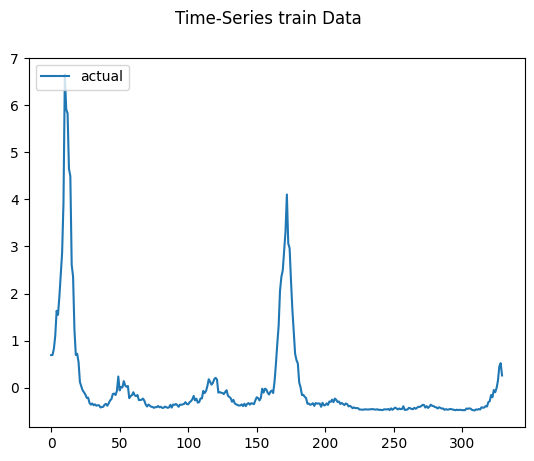

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           4024000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                                 
 dense (Dense)               (None, 250)               125250    
                                                                 
 batch_normalization (Batch  (None, 250)               1000      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 120)               30120     
                                                                 
 batch_normalization_1 (Bat  (None, 120)               480       
 chNormalization)                                       

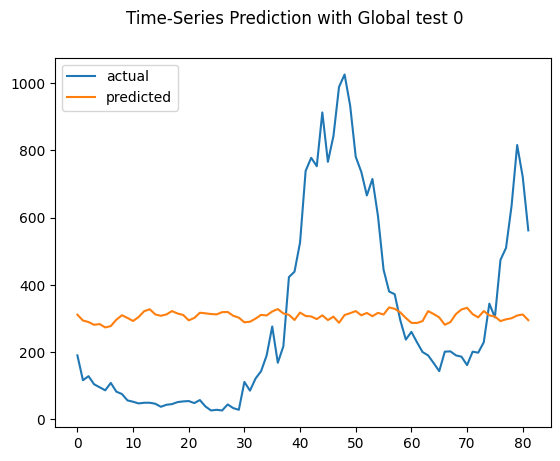

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 1000)           4024000   
                                                                 
 lstm_5 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_12 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_4 (Bat  (None, 250)               1000      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_5 (Bat  (None, 120)               480       
 chNormalization)                                     

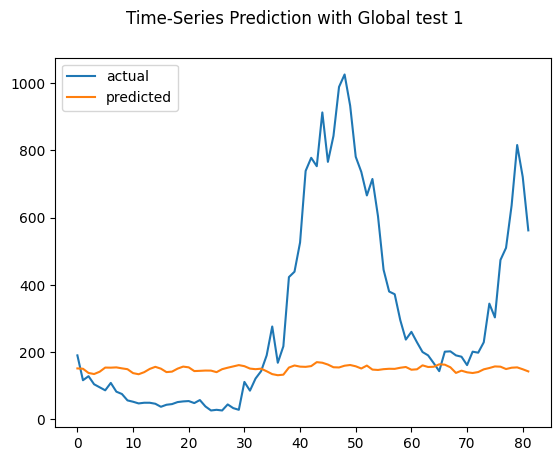

rmse : average=301.332, std=17.287
mae : average=228.238, std=10.614
smape : average=83.716, std=1.671
r2 : average=-0.129, std=0.129


([301.33211609185383, 17.287409233499943],
 [228.23823445017746, 10.613564374970224],
 [83.71551407571889, 1.6711777126442442],
 [-0.12874101741725602, 0.12908677268182306])

In [14]:
set_all_seeds(1)

if T != 0: 
    sequence=train_X.shape[1]
else:
    sequence=T

# Embedding data
x_ar = train_X[:, :, :1024]
x_ar_test = test_X[:, :, :1024]

# Metadata
train_X = train_X[:, :, 1024:]
test_X = test_X[:, :, 1024:]

calculate_mean_std(lstm_layers, nn_layers, sequence, train_X.shape[2], dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_cases'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion='joint', x_ar=x_ar, x_ar_test=x_ar_test)

# Time Series Cross Validation & Results


In [15]:
lstm_layers_gated = [1024, 512, 256]

In [16]:
n_splits = 2
#ar=False
df = dengue_df

def normalize_train_features_real(df, feature_range=(-1, 1), scaler=True, describe=None, min_max=None):

    scalers = {}
    scaler_real = StandardScaler()
    # For each column in the dataframe
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue

        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Generate a new scaler
        if min_max:
            scaler = MinMaxScaler(feature_range=feature_range)
        else:
            scaler = StandardScaler()
        try:
            # Fit the scaler just for that column
            scaled_column = scaler.fit_transform(values)
        except:
            continue

        # Add the scaled column to the dataframe
        scaled_column = np.reshape(scaled_column, len(scaled_column))
        df[column] = scaled_column

        # Save the scaler of the column
        scalers['scaler_' + column] = scaler
    scaler_real.fit(df['cases'].values.reshape(-1,1))
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df, scalers, scaler_real
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)
full_metrics = []



def time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=1, batch_size=1, attention=False, min_max=None):
  for i, (train_index, test_index) in enumerate(tscv.split(df.index)):
        print(f"Fold {i}:".center(100,"-"))
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        print(f"Shapes:  ", train_df.shape, test_df.shape)
        print(f"  Train: {train_df.index[0]} to {train_df.index[-1]}")
        print(f"  Test: {test_df.index[0]} to {test_df.index[-1]}")

        # Normalize
        train_df, scalers, scaler_r = normalize_train_features_real(train_df, feature_range=feature_range, min_max=min_max)
        # train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]
        test_df = normalize_test_features(test_df, scalers=scalers)
        # test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]
        # import pdb; pdb.set_trace()
        # # Supervised structure
        train = series_to_supervised(df, n_in=T, autoregressive=ar)
        test = series_to_supervised(df, n_in=T, autoregressive=ar)

        print(f"Supervised {train.shape}, {test.shape}")
        print('Train:')
        train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df, autoregressive=ar)
        print('Test:')
        test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df, autoregressive=ar)
        if T != 0:
            print("3D reshape: ")
            train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, ar)
            
        if T != 0: 
            sequence=train_X.shape[1]
        else:
            sequence=T
        
        # Embedding data
        x_ar = train_X[:, :, :1024]
        x_ar_test = test_X[:, :, :1024]
        
        x_ar_2 = train_X[:, :, -3]
        x_ar_test_2 = test_X[:, :, -3]

        # Metadata
        train_X = train_X[:, :, 1024:]
        test_X = test_X[:, :, 1024:]
        
        
        
        # Use the Function:
        if T != 0:
            sequence=train_X.shape[1]
            features=train_X.shape[2]
        else:
            sequence=T
            features=train_X.shape[1]

        true_scaler = scalers['scaler_cases']
        #mean = true_scaler.mean_
        #var = true_scaler.var_
        metrics  = calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler_r, monitor=False, plot=None, epochs=epochs, batch_size=batch_size, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, attention=attention, x_ar_2=None, x_ar_test_2=None)
        full_metrics.append(metrics)

  return full_metrics

## Late Dense Fusion (128)

----------------------------------------------Fold 0:-----------------------------------------------
Shapes:   (140, 1030) (138, 1030)
  Train: 0 to 139
  Test: 140 to 277
Supervised (414, 3088), (414, 3088)
Train:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
Test:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
3D reshape: 
The initial shapes are:
The train shape is (414, 3087)
The test shape is (414, 3087)
-----------------------
The Final shapes are:
The train shape is (414, 3, 1029)
The test shape is (414, 3, 1029)


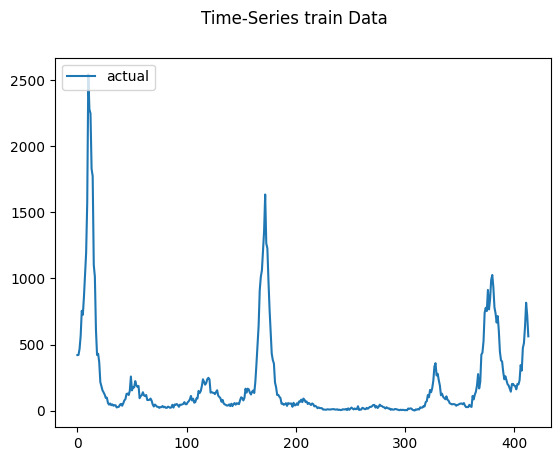

training the image model
training the second modality
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 1000)           4024000   
                                                                 
 lstm_9 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_24 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_8 (Bat  (None, 250)               1000      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_9 (Bat  (None, 120)               480       


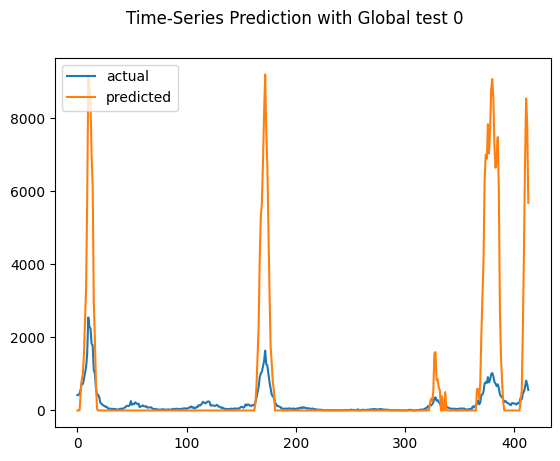

training the image model
training the second modality
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 1000)           4024000   
                                                                 
 lstm_13 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_36 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_12 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_37 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_13 (Ba  (None, 120)               480       

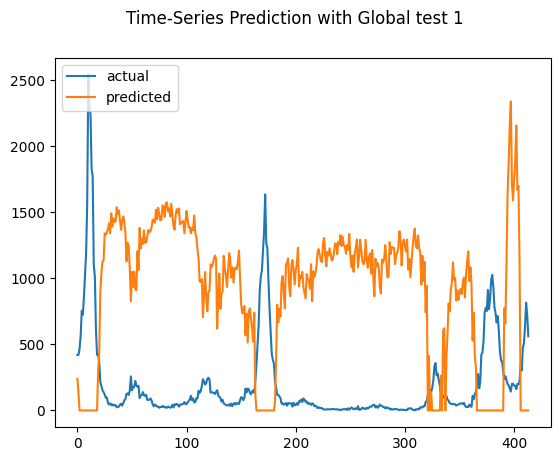

rmse : average=1429.308, std=361.364
mae : average=816.156, std=177.317
smape : average=180.571, std=2.420
r2 : average=-17.113, std=8.608
----------------------------------------------Fold 1:-----------------------------------------------
Shapes:   (278, 1030) (138, 1030)
  Train: 0 to 277
  Test: 278 to 415
Supervised (414, 3088), (414, 3088)
Train:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
Test:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
3D reshape: 
The initial shapes are:
The train shape is (414, 3087)
The test shape is (414, 3087)
-----------------------
The Final shapes are:
The train shape is (414, 3, 1029)
The test shape is (414, 3, 1029)


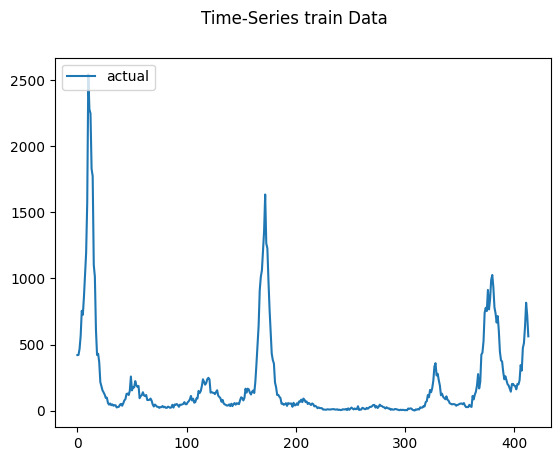

training the image model
training the second modality
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 1000)           4024000   
                                                                 
 lstm_17 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_48 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_16 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_49 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_17 (Ba  (None, 120)               480       

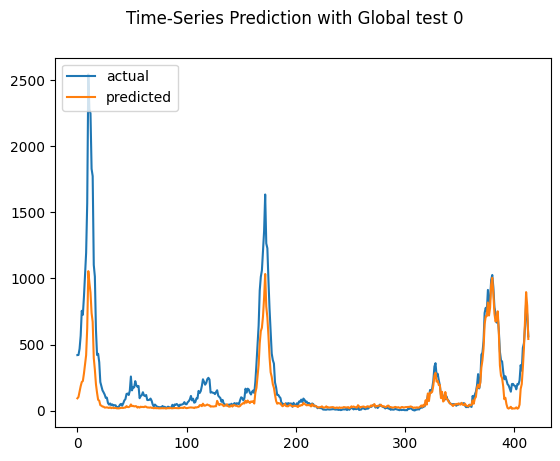

training the image model
training the second modality
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 1000)           4024000   
                                                                 
 lstm_21 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_60 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_20 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_61 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_21 (Ba  (None, 120)               480       

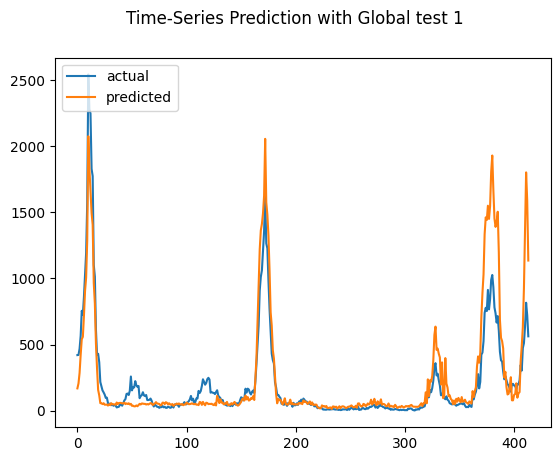

rmse : average=196.775, std=6.649
mae : average=93.480, std=3.471
smape : average=62.330, std=4.681
r2 : average=0.677, std=0.022


In [17]:
full_metrics = time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=50, batch_size=128, attention=False)
mean = [[sum(values) / len(values) for values in zip(*sublist)] for sublist in zip(*full_metrics)]

In [18]:
lstm_layers_gated = [1024, 512, 256]

## Late Dense Fusion with Attention (128)

----------------------------------------------Fold 0:-----------------------------------------------
Shapes:   (140, 1030) (138, 1030)
  Train: 0 to 139
  Test: 140 to 277
Supervised (414, 3088), (414, 3088)
Train:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
Test:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
3D reshape: 
The initial shapes are:
The train shape is (414, 3087)
The test shape is (414, 3087)
-----------------------
The Final shapes are:
The train shape is (414, 3, 1029)
The test shape is (414, 3, 1029)


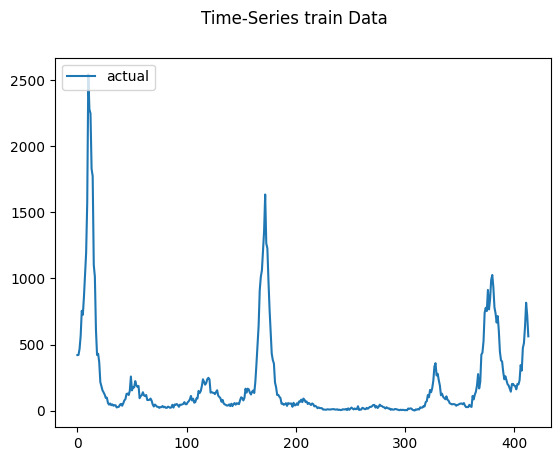

training the image model
training the second modality
trianing final model
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_24_input (InputLayer)  [(None, 3, 5)]               0         []                            
                                                                                                  
 sequential_26 (Sequential)  (None, 120)                  7182850   ['lstm_24_input[0][0]']       
                                                                                                  
 attn__net__gated (Attn_Net  (None, 1)                    15553     ['sequential_26[0][0]']       
 _Gated)                                                                                          
                                                                                                  
 tf.nn.softmax (T

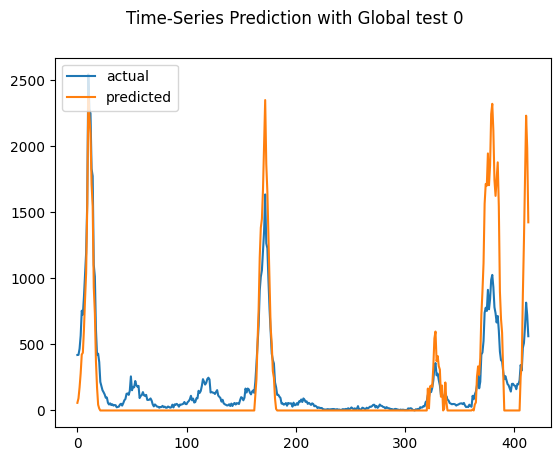

training the image model
training the second modality
trianing final model
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_28_input (InputLayer)  [(None, 3, 5)]               0         []                            
                                                                                                  
 sequential_32 (Sequential)  (None, 120)                  7182850   ['lstm_28_input[0][0]']       
                                                                                                  
 attn__net__gated_1 (Attn_N  (None, 1)                    15553     ['sequential_32[0][0]']       
 et_Gated)                                                                                        
                                                                                                  
 tf.nn.softmax_1 

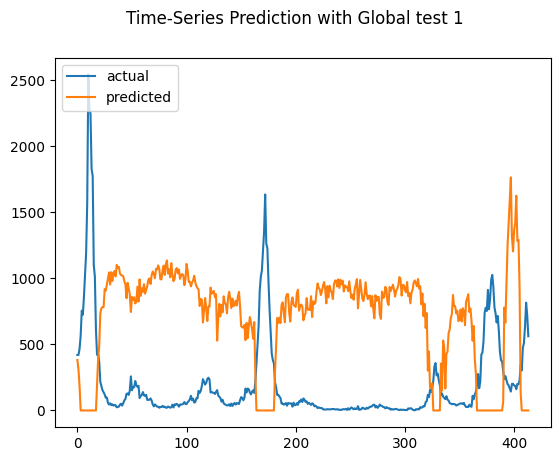

rmse : average=549.803, std=284.696
mae : average=457.266, std=320.977
smape : average=169.181, std=1.744
r2 : average=-2.194, std=2.609
----------------------------------------------Fold 1:-----------------------------------------------
Shapes:   (278, 1030) (138, 1030)
  Train: 0 to 277
  Test: 278 to 415
Supervised (414, 3088), (414, 3088)
Train:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
Test:
The shape of the features is (414, 3087)
The shape of the labels is (414, 1)
3D reshape: 
The initial shapes are:
The train shape is (414, 3087)
The test shape is (414, 3087)
-----------------------
The Final shapes are:
The train shape is (414, 3, 1029)
The test shape is (414, 3, 1029)


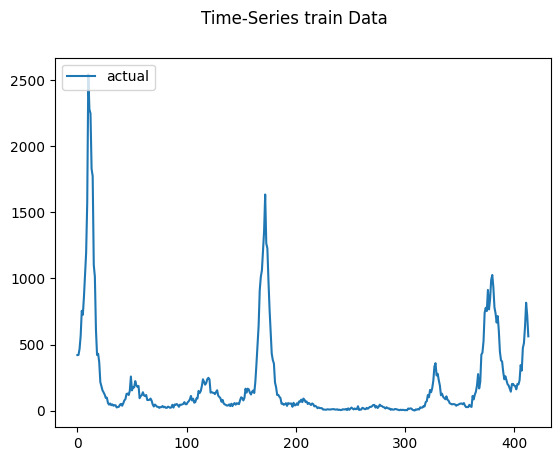

training the image model
training the second modality
trianing final model
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_32_input (InputLayer)  [(None, 3, 5)]               0         []                            
                                                                                                  
 sequential_38 (Sequential)  (None, 120)                  7182850   ['lstm_32_input[0][0]']       
                                                                                                  
 attn__net__gated_2 (Attn_N  (None, 1)                    15553     ['sequential_38[0][0]']       
 et_Gated)                                                                                        
                                                                                                  
 tf.nn.softmax_2 

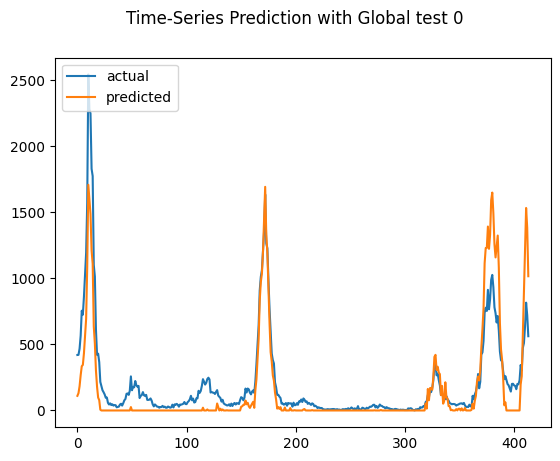

training the image model
training the second modality
trianing final model
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_36_input (InputLayer)  [(None, 3, 5)]               0         []                            
                                                                                                  
 sequential_44 (Sequential)  (None, 120)                  7182850   ['lstm_36_input[0][0]']       
                                                                                                  
 attn__net__gated_3 (Attn_N  (None, 1)                    15553     ['sequential_44[0][0]']       
 et_Gated)                                                                                        
                                                                                                  
 tf.nn.softmax_3 

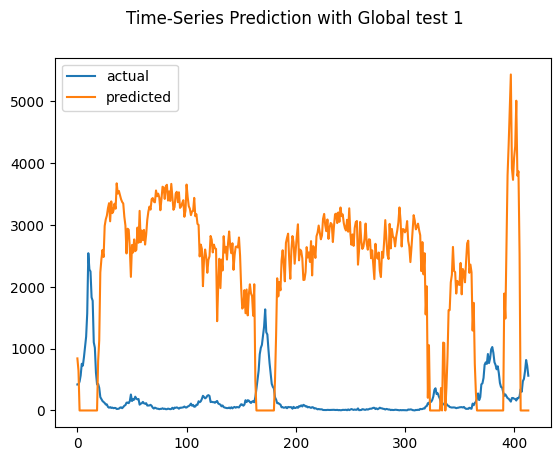

rmse : average=1326.220, std=1149.403
mae : average=1180.130, std=1076.044
smape : average=171.441, std=17.352
r2 : average=-24.667, std=25.406


In [19]:
full_metrics = time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=50, batch_size=128, attention=True)
mean = [[sum(values) / len(values) for values in zip(*sublist)] for sublist in zip(*full_metrics)]